## Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import cv2 as cv
from pylab import *
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

parentdir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(parentdir, 'py'))
sys.path.append(os.path.join(parentdir, 'paraviewscripts'))

import folderparser as fp
import folderscraper as fs
import interfacemetrics as intm
from interfacePlots import *
from config import cfg

In [3]:
SERVERFOLDER = cfg.path.server
EXPORTFOLDER = cfg.path.fig
TOPFOLDER = SERVERFOLDER

## Legend Creation

In [4]:
o = []
folders = SERVERFOLDER
for topfolder in [folders]:
    for f in fp.caseFolders(topfolder):
        fs.populate(f) # adds times to legends
        l = fp.legendUnique(f)
        if len(l)>0:
            o.append(l)
p = pd.DataFrame(o) # compiles all legends
p.to_csv(r'\\cfs2e.nist.gov\642\NIST_Projects\Additive Manufacturing and Rheology\OpenFOAM\simulations\viscositysweep\adjacent\legend_mesh.csv')

In [5]:
o = []
for topfolder in [SERVERFOLDER]:
    for f in fp.caseFolders(topfolder):
        l = fp.legendUnique(os.path.join(topfolder, f))
        if len(l)>0:
            o.append(l)
p = pd.DataFrame(o)
p.to_csv(os.path.join(SERVERFOLDER, 'legend_general.csv'))

## Visualizations

In [6]:
def getSweeps(TOPFOLDER:str, sims:List[List[int]]=[]):
    '''breaks all sim folders into sweeps of matching simulations with different offsets if sims is empty
    otherwise, uses the sweeps as declared by the lists in sims
    returns list of lists of paths to the images folder for each sim'''
    if sims:
        folders = []
        for j in sims:
            sweep = []
            for i in j:
                sweep.append(os.path.join(TOPFOLDER,'aj'+str(i),'images'))
            folders.append(sweep)
        return folders
    folders = [os.path.join(TOPFOLDER,i,'images') for i in fp.caseFolders(TOPFOLDER)]
    fnames = [os.path.basename(os.path.dirname(i)) for i in folders]
    fnums = [(int(i[2:])-1)//6 for i in fnames]
    uniq = np.unique(fnums)
    sweeps = [[] for i in range(len(uniq))]
    for i,num in enumerate(fnums):
        for j,sweep in enumerate(uniq):
            if num==sweep:
                sweeps[j].append(folders[i])
    return sweeps

In [45]:
def crossSectionsSweep(fname:str='cross_sections_sweep'):
    '''plots crosss sections of ink, one column for each sweep'''
    # plt.suptitle('Cross sections')
    plt.suptitle('Offset (di)')
    for k,sweep in enumerate(sweeps):
        fsweep = [os.path.basename(os.path.dirname(i)) for i in sweep]
        d = [int(i[2:]) for i in fsweep]
        d = [(i-1)%6 for i in d]
        d = [i+1 if i==5 else i for i in d]
        d = [i*0.125+0.5 for i in d]

        for j,folder in enumerate(sweep):
            if os.path.exists(os.path.join(folder,'t025_x_alphaSlice_1.4.png')):
                im = os.path.join(folder,'t025_x_alphaSlice_2.0.png')
            else:
                im = os.path.join(folder,'t020_x_alphaSlice_2.0.png')
            plt.subplot(len(sweeps),7,k*7+j+1)
            img = mpimg.imread(im)
            plt.imshow(img[240:500, 480:740])
            # plt.title(os.path.basename(os.path.dirname(os.path.dirname(im))))
            plt.title(d[j])
            plt.xticks([])
            plt.yticks([])
        # nb = [f for f in os.listdir(sweep[0]) if f.startswith('nb')]
        # im = os.path.join(sweep[0],nb[0])
            if os.path.exists(os.path.join(folder,'t025_x_alphaSlice_-4.0.png')):
                im = os.path.join(folder,'t025_x_alphaSlice_-4.0.png')
            else:
                im = os.path.join(folder,'t020_x_alphaSlice_-4.0.png')
        plt.subplot(len(sweeps),7,k*7+7)
        img = mpimg.imread(im)
        plt.imshow(img[240:500, 480:740])
        # plt.title(nb[0].split('_')[0])
        plt.title('Ideal')
        plt.xticks([])
        plt.yticks([])
    plt.savefig(os.path.join(TOPFOLDER,'figures',fname))

In [8]:
def crossSectionsNoExt(fname:str='cross_sections_no_extrusion'):
    '''plots quality metrics for line disturbed by nozzle'''
    plt.suptitle('Cross sections no extrusion')
    folders = [os.path.join(TOPFOLDER, f, 'images') for f in ['aj16','aj22','aj16','aj40']]
    nb = [f for folder in folders for f in os.listdir(folder) if f.startswith('nb')]
    images = []
    for i,f in enumerate(folders):
        images.append(os.path.join(f, 't025_x_alphaSlice_1.4.png'))
        images.append(os.path.join(f, nb[i]))
    for i,im in enumerate(images):
        plt.subplot(2,4,i+1)
        img = mpimg.imread(im)
        plt.imshow(img[240:500, 480:740])
        if os.path.basename(im).startswith('nb'):
            plt.title(os.path.basename(im).split('_')[0])
        else:
            plt.title(os.path.basename(os.path.dirname(os.path.dirname(im))))
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.ylabel('0 vs 40 sigma (NN)', rotation=0)
        elif i==4:
            plt.ylabel('newt vs HB', rotation=0)
    plt.savefig(os.path.join(TOPFOLDER,'figures',fname))

In [41]:
def crossSectionsModelSigma(fname:str='cross_sections_sweep'):
    '''plots comparing interfacial tensions for each model'''
    plt.suptitle('Cross sections')
    ylabels = ['NN','HBHB','HBN','NHB']
    xlabels = ['0','40']
    
    for k,sweep in enumerate(sweeps):
        for j,folder in enumerate(sweep):
            if os.path.exists(os.path.join(folder,'t025_x_alphaSlice_1.4.png')):
                im = os.path.join(folder,'t025_x_alphaSlice_1.4.png')
            else:
                im = os.path.join(folder,'t020_x_alphaSlice_1.4.png')
            plt.subplot(len(sweeps),2,k*2+j+1)
            img = mpimg.imread(im)
            plt.imshow(img[240:500, 480:740])
            # plt.title(os.path.basename(os.path.dirname(os.path.dirname(im))))
            plt.xticks([])
            plt.yticks([])
            if k==0:
                # plt.title(xlabels[j]+'\n'+os.path.basename(os.path.dirname(os.path.dirname(im))))
                plt.title(xlabels[j])
            if j==0:
                plt.ylabel(ylabels[k])
    plt.savefig(os.path.join(TOPFOLDER,'figures',fname))

In [10]:
def crossSectionsModel(fname:str='cross_sections_sweep'):
    '''plots comparing different models of ink and support'''
    plt.suptitle('Cross sections')
    xlabels = ['NN','HBHB','HBN','NHB']
    
    for k,sweep in enumerate(sweeps):
        for j,folder in enumerate(sweep):
            if os.path.exists(os.path.join(folder,'t025_x_alphaSlice_1.4.png')):
                im = os.path.join(folder,'t025_x_alphaSlice_1.4.png')
            else:
                im = os.path.join(folder,'t015_x_alphaSlice_1.4.png')
            plt.subplot(1,len(sweep),j+1)
            img = mpimg.imread(im)
            plt.imshow(img[240:500, 480:740])
            # plt.title(os.path.basename(os.path.dirname(os.path.dirname(im))))
            plt.xticks([])
            plt.yticks([])
            if k==0:
                # plt.title(xlabels[j]+'\n'+os.path.basename(os.path.dirname(os.path.dirname(im))))
                plt.title(xlabels[j])
    plt.savefig(os.path.join(TOPFOLDER,'figures',fname))

## Driver Code

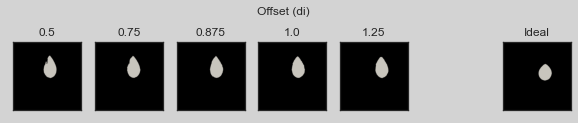

In [49]:
import matplotlib.image as mpimg

sweeps = getSweeps(TOPFOLDER, sims=[[13,15,16,17,18]])
plt.rcParams["figure.figsize"] = (len(sweeps[0])*2,len(sweeps)*2)

fig = plt.figure(facecolor='lightgrey')
# plt.tight_layout()

crossSectionsSweep(fname='NN0y0_sweep_cross_sections')

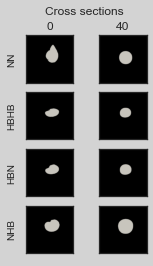

In [51]:
# sweeps = getSweeps(TOPFOLDER)
sweeps = getSweeps(TOPFOLDER, sims=[[4,10],[28,34],[52,58],[76,82]])

plt.rcParams["figure.figsize"] = (len(sweeps[0])*1.2,len(sweeps)*1)
fig = plt.figure(facecolor='lightgrey')
plt.tight_layout()

crossSectionsModelSigma(fname='models_sigmas_sweep_cross_sections')

## Numerical Metrics

In [37]:
def plotMetrics(data:List[List[float]],cordata:List[List[float]],sweep:List[List[str]],nums:List[str],
                d:List[float],j:int,k:int,nozline:bool=True):
    '''plots fusion quality metrics'''
    xvals = linspace(nums[0],nums[-1],len(data[0]))
    
    for l,metric in enumerate(metrics):
        plt.subplot(len(sweeps),len(metrics),k*len(metrics)+l+1)
        plt.plot(xvals, data[l], label=str(d[j]), color=colormap[j], linewidth=lw, alpha=alpha)
        # plt.plot(xvals, data[l], label=os.path.basename(os.path.dirname(sweep[j])), color=colormap[j], linewidth=lw, alpha=alpha)
        if 0<plt.ylim()[0]:
            plt.ylim(ymin=0)
            plt.ylim(ymax=0.67)
        if l==0: # only add to left plots
            plt.ylabel('Unitless')
            # plt.ylabel(os.path.basename(os.path.dirname(sweep[0]))+'-'+os.path.basename(os.path.dirname(sweep[-1])))
        if k==0: # only add to top plots
            plt.title(metric)
        if k==len(sweeps)-1: # only add to bottom plots
            plt.xlabel('x bath pos (mm)')
        if j==len(sweep)-1: # only add once per plot
            plt.scatter(1.4, cordata[l], s=s, color='b', alpha=alpha)
            if nozline==True:
                plt.axvline(-3.167, label = 'Nozzle bounds', linestyle = '--', color = 'k')
                plt.axvline(-1.657, linestyle = '--', color = 'k')
            plt.legend(fontsize=9)
        # if l==len(metrics)-1: # only add to right plots
            # plt.legend(fontsize=9)
        
    # plt.legend(bbox_to_anchor=(1.8,1.0))

In [16]:
def metricsFullLine(fname='full_line_metrics'):
    '''collects metrics for the full length of the bath'''
    for k,sweep in enumerate(sweeps): # get metrics for all simulations
        # get offset distances
        fsweep = [os.path.basename(os.path.dirname(i)) for i in sweep]
        d = [int(i[2:]) for i in fsweep]
        d = [(i-1)%6 for i in d]
        d = [i+1 if i==5 else i for i in d]
        d = [i*0.125+0.5 for i in d]

        for j,folder in enumerate(sweep):
            images = [i for i in os.listdir(folder) if i.startswith("t025_x_alphaSlice_")]
            images2 = [i for i in os.listdir(folder) if i.startswith("t020_x_alphaSlice_")] # for partially finished sims
            images = images+images2
            nums = [i.split('ice_')[1] for i in images]
            nums = [i.split('.p')[0] for i in nums]
            nums = np.asarray(nums, dtype=float)
            idx = np.argsort(nums)
            nums = [nums[i] for i in idx]
            images = [images[i] for i in idx]

            # metrics at each slice
            aa = []; bb = []; cc = []; dd = []; ee = []; ff = []; gg = []
            for image in images:
                img = os.path.join(folder, image)
                im = cv.imread(img)
                if int(os.path.basename(os.path.dirname(folder))[2:])%24>11:
                    aa.append(sm.getPerimeter(im,1))
                else:
                    aa.append(sm.getPerimeter(im,2))
                bb.append(sm.getRoughness(im))
                cc.append(sm.asymmetry(im,True)[0])
                dd.append(sm.asymmetry(im,True)[1])
                ee.append(sm.asymmetry(im,False)[0])
                ff.append(sm.asymmetry(im,False)[1])
                gg.append(sm.fused(im))

            # comparisons with corresponding simulation
            image1 = os.path.join(folder, 't025_x_alphaSlice_1.4.png')
            image2 = [i for i in os.listdir(folder) if i.startswith("nb")]
            image2 = os.path.join(folder, image2[0])
            im1 = cv.imread(image1)
            im2 = cv.imread(image2)

            # corresponding simulation
            aa1 = sm.getPerimeter(im2,1)
            bb1 = sm.getRoughness(im2)
            cc1 = sm.asymmetry(im2,True)[0]
            dd1 = sm.asymmetry(im2,True)[1]
            ee1 = sm.asymmetry(im2,False)[0]
            ff1 = sm.asymmetry(im2,False)[1]

            dataDict = {'Normalized Perimeter':aa, 'Roughness':bb, 'Horizontal Asymmetry':cc, 'Horizontal Deviation':dd,
                        'Vertical Asymmetry':ee, 'Vertical Deviation':ff}
            cordataDict = {'Normalized Perimeter':aa1, 'Roughness':bb1, 'Horizontal Asymmetry':cc1, 'Horizontal Deviation':dd1,
                        'Vertical Asymmetry':ee1, 'Vertical Deviation':ff1}
            data = [dataDict[m] for m in metrics]
            cordata = [cordataDict[m] for m in metrics]

            plotMetrics(data,cordata,sweep,nums,d,j,k,True)
    plt.savefig(os.path.join(TOPFOLDER,'figures',fname))

In [13]:
def metricsAfterNozzle(fname='after_nozzle_metrics'):
    '''collects metrics for a line after being passed by the nozzle'''
    for k,sweep in enumerate(sweeps): # get metrics for all simulations
        # get offset distances
        fsweep = [os.path.basename(os.path.dirname(i)) for i in sweep]
        d = [int(i[2:]) for i in fsweep]
        d = [(i-1)%6 for i in d]
        d = [i+1 if i==5 else i for i in d]
        d = [i*0.125+0.5 for i in d]

        for j,folder in enumerate(sweep):
            images = [i for i in os.listdir(folder) if i.startswith("t025_x_alphaSlice_")]
            images = [i for i in images if float(i.split('_')[-1].split('.png')[0])>=0]
            
            nums = [i.split('ice_')[1] for i in images]
            nums = [i.split('.png')[0] for i in nums]
            nums = np.asarray(nums, dtype=float)
            idx = np.argsort(nums)
            nums = [nums[i] for i in idx]
            images = [images[i] for i in idx]

            # metrics at each slice
            aa = []; bb = []; cc = []; dd = []; ee = []; ff = []; gg = []
            for image in images:
                img = os.path.join(folder, image)
                im = cv.imread(img)
                if int(os.path.basename(os.path.dirname(folder))[2:])%24>11:
                    aa.append(sm.getPerimeter(im,1))
                else:
                    aa.append(sm.getPerimeter(im,2))
                bb.append(sm.getRoughness(im))
                cc.append(sm.asymmetry(im,True)[0])
                dd.append(sm.asymmetry(im,True)[1])
                ee.append(sm.asymmetry(im,False)[0])
                ff.append(sm.asymmetry(im,False)[1])
                gg.append(sm.fused(im))

            # comparisons with corresponding simulation
            image1 = os.path.join(folder, 't025_x_alphaSlice_1.4.png')
            image2 = [i for i in os.listdir(folder) if i.startswith("nb")]
            image2 = os.path.join(folder, image2[0])
            im1 = cv.imread(image1)
            im2 = cv.imread(image2)

            # corresponding simulation
            aa1 = sm.getPerimeter(im2,1)
            bb1 = sm.getRoughness(im2)
            cc1 = sm.asymmetry(im2,True)[0]
            dd1 = sm.asymmetry(im2,True)[1]
            ee1 = sm.asymmetry(im2,False)[0]
            ff1 = sm.asymmetry(im2,False)[1]

            data = [aa, bb, cc, ee]
            cordata = [aa1, bb1, cc1, ee1]
            # data = [aa, bb, cc, dd, ee, ff] # with deviations
            # cordata = [aa1, bb1, cc1, dd1, ee1, ff1]

            plotMetrics(data,cordata,sweep,nums,d,j,k,False)
    plt.savefig(os.path.join(TOPFOLDER,'figures',fname))

In [14]:
def metricsNoExt(fname='no_extrusion_metrics'):
    '''collects metrics for horizontal and vertical displacement
    to be used with no extrusion sims'''
    for k,sweep in enumerate(sweeps): # get metrics for all simulations
        # get offset distances
        fsweep = [os.path.basename(os.path.dirname(i)) for i in sweep]
        d = [int(i[2:]) for i in fsweep]
        d = [(i-1)%6 for i in d]
        d = [i+1 if i==5 else i for i in d]
        d = [i*0.125+0.5 for i in d]

        aa = []
        bb = []
        for j,folder in enumerate(sweep):
            image1 = os.path.join(folder, 't025_x_alphaSlice_1.4.png')
            image2 = os.path.join(folder, 't025_x_alphaSlice_-4.0.png')
            im1 = cv.imread(image1)
            im2 = cv.imread(image2)
            aa.append(sm.dispY(im1,im2,1))
            bb.append(sm.dispZ(im1,im2,1))

        data = [aa, bb]
        plotNoExtMetrics(data)
    plt.savefig(os.path.join(TOPFOLDER,'figures',fname))

## Driver code

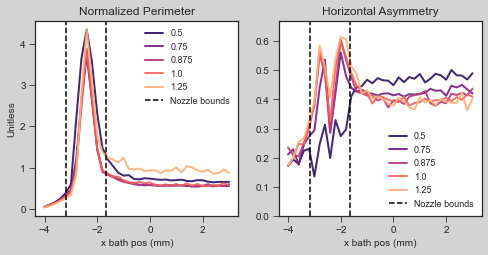

In [38]:
import sim_metrics as sm

# go through each metric and plot each simulation within the sweep. One plot for each sweep.

# metrics = ['Perimeter', 'Roughness', 'Horizontal Asymmetry', 'Vertical Asymmetry']
metrics = ['Normalized Perimeter', 'Horizontal Asymmetry']
# metrics = ['Perimeter', 'Roughness', 'Horizontal Symmetry', 'Horizontal Deviation', 'Vertical Symmetry', 'Vertical Deviation']

# sweeps = getSweeps(TOPFOLDER) # all sims
# sweeps = getSweeps(TOPFOLDER, sims=[[13,15,16,17,18]]) # NN0y0
sweeps = getSweeps(TOPFOLDER, sims=[[1,3,4,5,6]]) # offsets NN0y, HBHB0y
# sweeps = getSweeps(TOPFOLDER, sims=[[4,28,52,76]]) # models
# sweeps = getSweeps(TOPFOLDER, sims = [[4,28,52,76],[10,34,58,82]]) # models and tensions

sweeps = [s for s in sweeps if len(s)>1] # only offset sweeps

# plot setup
plt.rcParams["figure.figsize"] = (len(metrics)*4,len(sweeps)*3.6)
fig = plt.figure(facecolor='lightgrey')
plt.style.use('seaborn-ticks')
# plt.suptitle('Fusion Metrics')
plt.tight_layout()
colormap = sns.color_palette("magma", n_colors=len(sweeps[0]))
s = 50; lw = 2; alpha = 0.9
s = 0 # remove point

metricsFullLine(fname='offsets_NN0y_perimeter_horasym_FullNozzle')
# metricsFullLine(fname='NN0y0_perimeter_horasym_FullNozzle')